# 4.6 Borrow Cost & Tradability Analysis

Estimate whether the sweet spot ($1M-$8M daily volume) is actually tradeable:
1. Scrape IBorrowDesk for historical borrow rates
2. Estimate bid-ask spreads from OHLC data
3. Flag likely hard-to-borrow stocks
4. Calculate net returns after estimated costs

In [7]:
import sys
sys.path.insert(0, '.')

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import requests
from bs4 import BeautifulSoup
import time
from pathlib import Path

from trading.model import ModelInference

plt.style.use('seaborn-v0_8-whitegrid')
plt.rcParams['figure.figsize'] = (14, 5)

In [8]:
# Load model and recreate shorts analysis
MODEL_PATH = Path('data/model_robust_optimized.pt')
model = ModelInference(MODEL_PATH)

df = pd.read_parquet('data/ml_dataset.pqt')
df['feature_date'] = pd.to_datetime(df['feature_date'])
df['simple_return'] = np.exp(df['target_return']) - 1

TEST_START = '2024-10-22'
test_df = df[df['feature_date'] >= TEST_START].copy()

# Filter to news-only
emb_cols = [c for c in test_df.columns if c.startswith('emb_')]
has_news = (test_df[emb_cols].abs().sum(axis=1) > 0)
test_news = test_df[has_news].copy()
test_news['score'] = model.score(test_news)

print(f"Test period: {test_news['feature_date'].min().date()} to {test_news['feature_date'].max().date()}")

Test period: 2024-10-22 to 2025-12-18


In [9]:
# Get shorts and merge with price stats
K = 5
shorts_list = []
for date, group in test_news.groupby('feature_date'):
    if len(group) < 10:
        continue
    bottom_k = group.nsmallest(K, 'score')
    for _, row in bottom_k.iterrows():
        shorts_list.append({
            'date': date,
            'symbol': row['symbol'],
            'score': row['score'],
            'simple_return': row['simple_return'],
        })
shorts_df = pd.DataFrame(shorts_list)

# Load prices and compute stats
prices_df = pd.read_parquet('data/prices.pqt')
prices_df['date'] = pd.to_datetime(prices_df['date'])
prices_df['dollar_volume'] = prices_df['volume'] * prices_df['close']

test_prices = prices_df[prices_df['date'] >= TEST_START].copy()
symbol_stats = test_prices.groupby('symbol').agg({
    'close': 'mean',
    'volume': 'mean',
    'dollar_volume': 'mean',
}).round(2)
symbol_stats.columns = ['avg_price', 'avg_volume', 'avg_dollar_volume']

shorts_with_stats = shorts_df.merge(symbol_stats.reset_index(), on='symbol', how='left')

# Filter to sweet spot ($1M-$8M)
sweet_spot = shorts_with_stats[
    (shorts_with_stats['avg_dollar_volume'] >= 1e6) & 
    (shorts_with_stats['avg_dollar_volume'] < 8e6)
].copy()

print(f"Sweet spot positions: {len(sweet_spot)}")
print(f"Unique symbols: {sweet_spot['symbol'].nunique()}")

Sweet spot positions: 260
Unique symbols: 124


In [10]:
# Get unique sweet spot symbols sorted by frequency
sweet_symbols = sweet_spot.groupby('symbol').agg({
    'date': 'count',
    'simple_return': 'mean',
    'avg_dollar_volume': 'first',
    'avg_price': 'first'
}).rename(columns={'date': 'times_shorted'})
sweet_symbols['short_return'] = -sweet_symbols['simple_return']
sweet_symbols = sweet_symbols.sort_values('times_shorted', ascending=False)

print(f"Top 30 sweet spot symbols:")
print(sweet_symbols.head(30)[['times_shorted', 'short_return', 'avg_dollar_volume', 'avg_price']].round(4).to_string())

Top 30 sweet spot symbols:
        times_shorted  short_return  avg_dollar_volume  avg_price
symbol                                                           
HSDT               10        0.0650         5987011.16     197.78
BCTX                9        0.0194         6339540.86      41.08
ACON                7        0.0228         6182966.13      65.29
NGNE                5        0.1147         5907363.22      21.91
GNPX                5        0.0459         7381191.58      23.96
NUWE                5        0.1203         4793275.39      29.42
HCWB                5        0.0625         7108155.78       9.31
SPPL                5        0.0379         3346204.24       4.82
BIVI                4       -0.0148         2352674.00      11.18
FWDI                4        0.0087         3457135.84       9.37
FLYE                4        0.0531         4582978.28      47.04
GWAV                4        0.0368         3987719.90      27.20
TARA                4        0.0154         45616

## 1. Borrow Rate Estimates

IBorrowDesk now uses JavaScript rendering, so we'll estimate borrow rates based on stock characteristics instead.

Typical borrow rates by category:
- Easy to borrow (large cap, liquid): 0.3-1%
- General collateral: 1-3%
- Hard to borrow (small cap, volatile): 5-30%
- Very hard to borrow (meme stocks, heavily shorted): 30-100%+

In [11]:
# Skip IBorrowDesk - site now uses JavaScript rendering
# Create empty borrow_df for compatibility with later cells
borrow_df = pd.DataFrame({
    'symbol': sweet_symbols.index.tolist(),
    'status': 'not_available',
    'fee_rate': None,
    'available': None
})
print("IBorrowDesk scraping skipped (site now uses JS rendering)") 
print("Will estimate borrow rates from stock characteristics instead")

IBorrowDesk scraping skipped (site now uses JS rendering)
Will estimate borrow rates from stock characteristics instead


In [12]:
# Cell removed - was IBorrowDesk fetching loop
pass

In [13]:
# No IBorrowDesk data available
print("BORROW RATE DATA")
print("=" * 60)
print("\nNo direct borrow data available (IBorrowDesk uses JS rendering)")
print("Will estimate rates based on stock characteristics in section 3")

BORROW RATE DATA

No direct borrow data available (IBorrowDesk uses JS rendering)
Will estimate rates based on stock characteristics in section 3


## 2. Spread Estimation from OHLC

Use Corwin-Schultz (2012) high-low spread estimator

In [14]:
def estimate_spread_hl(prices_df, symbol):
    """
    Estimate bid-ask spread using high-low range.
    Simple approach: spread ≈ (high - low) / ((high + low) / 2)
    More sophisticated: Corwin-Schultz estimator
    """
    sym_prices = prices_df[prices_df['symbol'] == symbol].copy()
    if len(sym_prices) < 20:
        return None
    
    # Simple high-low spread proxy
    sym_prices['hl_spread'] = (sym_prices['high'] - sym_prices['low']) / sym_prices['close']
    
    # Use median to be robust to outliers (earnings days, etc.)
    median_spread = sym_prices['hl_spread'].median()
    
    # High-low overestimates spread by ~2-3x due to intraday volatility
    # Empirical adjustment factor
    estimated_spread = median_spread / 2.5
    
    return {
        'symbol': symbol,
        'raw_hl_spread': median_spread,
        'estimated_spread': estimated_spread,
        'n_days': len(sym_prices)
    }

# Calculate spreads for all sweet spot symbols
spread_data = []
for symbol in sweet_symbols.index:
    result = estimate_spread_hl(test_prices, symbol)
    if result:
        spread_data.append(result)

spread_df = pd.DataFrame(spread_data)
print(f"Calculated spreads for {len(spread_df)} symbols")

Calculated spreads for 124 symbols


In [15]:
# Analyze spreads
print("ESTIMATED BID-ASK SPREADS")
print("=" * 60)

print(f"\nSpread statistics:")
print(f"  Min: {spread_df['estimated_spread'].min()*100:.2f}%")
print(f"  25th: {spread_df['estimated_spread'].quantile(0.25)*100:.2f}%")
print(f"  Median: {spread_df['estimated_spread'].median()*100:.2f}%")
print(f"  75th: {spread_df['estimated_spread'].quantile(0.75)*100:.2f}%")
print(f"  Max: {spread_df['estimated_spread'].max()*100:.2f}%")

# Categorize
spread_df['spread_category'] = pd.cut(
    spread_df['estimated_spread'],
    bins=[0, 0.005, 0.01, 0.02, 0.05, float('inf')],
    labels=['Tight (<0.5%)', 'Normal (0.5-1%)', 'Wide (1-2%)', 'Very Wide (2-5%)', 'Extreme (>5%)']
)
print(f"\nSpread distribution:")
print(spread_df['spread_category'].value_counts().to_string())

ESTIMATED BID-ASK SPREADS

Spread statistics:
  Min: 0.35%
  25th: 3.06%
  Median: 3.47%
  75th: 3.94%
  Max: 5.59%

Spread distribution:
spread_category
Very Wide (2-5%)    119
Wide (1-2%)           2
Extreme (>5%)         2
Tight (<0.5%)         1
Normal (0.5-1%)       0


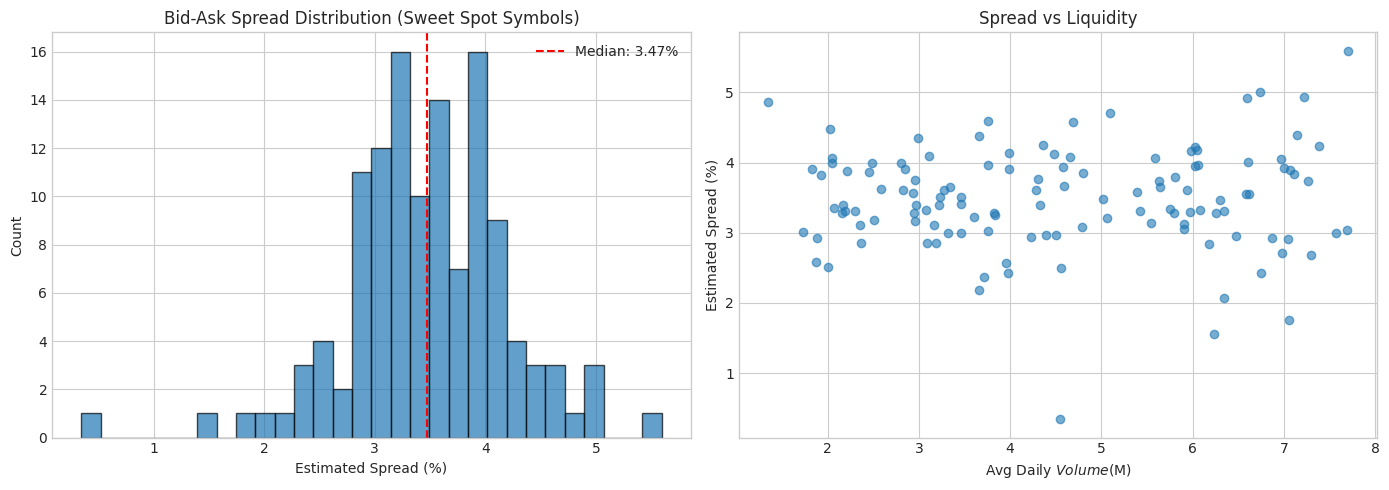

In [16]:
# Visualize spread distribution
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

ax = axes[0]
ax.hist(spread_df['estimated_spread'] * 100, bins=30, edgecolor='black', alpha=0.7)
ax.axvline(spread_df['estimated_spread'].median() * 100, color='red', linestyle='--', 
           label=f'Median: {spread_df["estimated_spread"].median()*100:.2f}%')
ax.set_xlabel('Estimated Spread (%)')
ax.set_ylabel('Count')
ax.set_title('Bid-Ask Spread Distribution (Sweet Spot Symbols)')
ax.legend()

# Spread vs dollar volume
ax = axes[1]
merged = spread_df.merge(sweet_symbols.reset_index(), on='symbol')
ax.scatter(merged['avg_dollar_volume'] / 1e6, merged['estimated_spread'] * 100, alpha=0.6)
ax.set_xlabel('Avg Daily $ Volume ($M)')
ax.set_ylabel('Estimated Spread (%)')
ax.set_title('Spread vs Liquidity')

plt.tight_layout()
plt.show()

## 3. HTB Risk Flags

Flag stocks likely to be hard-to-borrow based on characteristics

In [17]:
# Compute additional risk metrics
def compute_htb_flags(prices_df, symbol):
    """Compute flags indicating likely hard-to-borrow status."""
    sym = prices_df[prices_df['symbol'] == symbol].copy()
    if len(sym) < 20:
        return None
    
    sym = sym.sort_values('date')
    sym['return'] = sym['close'].pct_change()
    
    return {
        'symbol': symbol,
        'avg_price': sym['close'].mean(),
        'min_price': sym['close'].min(),
        'volatility': sym['return'].std() * np.sqrt(252),  # Annualized
        'volume_cv': sym['volume'].std() / sym['volume'].mean(),  # Coefficient of variation
        'max_daily_move': sym['return'].abs().max(),
        'pct_days_gt_5pct': (sym['return'].abs() > 0.05).mean(),
    }

htb_flags = []
for symbol in sweet_symbols.index:
    result = compute_htb_flags(test_prices, symbol)
    if result:
        htb_flags.append(result)

htb_df = pd.DataFrame(htb_flags)
print(f"Computed HTB flags for {len(htb_df)} symbols")

Computed HTB flags for 124 symbols


In [18]:
# Score HTB likelihood
htb_df['htb_score'] = 0

# Penny stock flag
htb_df['is_penny'] = htb_df['avg_price'] < 5
htb_df.loc[htb_df['is_penny'], 'htb_score'] += 2

# High volatility flag
htb_df['is_volatile'] = htb_df['volatility'] > 1.0  # >100% annual vol
htb_df.loc[htb_df['is_volatile'], 'htb_score'] += 1

# Erratic volume flag
htb_df['erratic_volume'] = htb_df['volume_cv'] > 1.5
htb_df.loc[htb_df['erratic_volume'], 'htb_score'] += 1

# Frequent big moves
htb_df['frequent_jumps'] = htb_df['pct_days_gt_5pct'] > 0.1  # >10% of days have 5%+ moves
htb_df.loc[htb_df['frequent_jumps'], 'htb_score'] += 1

print("HTB RISK FLAGS")
print("=" * 60)
print(f"\nPenny stocks (<$5): {htb_df['is_penny'].sum()} ({htb_df['is_penny'].mean()*100:.1f}%)")
print(f"High volatility (>100% ann): {htb_df['is_volatile'].sum()} ({htb_df['is_volatile'].mean()*100:.1f}%)")
print(f"Erratic volume (CV>1.5): {htb_df['erratic_volume'].sum()} ({htb_df['erratic_volume'].mean()*100:.1f}%)")
print(f"Frequent jumps (>10% days): {htb_df['frequent_jumps'].sum()} ({htb_df['frequent_jumps'].mean()*100:.1f}%)")

print(f"\nHTB Score Distribution:")
print(htb_df['htb_score'].value_counts().sort_index().to_string())

HTB RISK FLAGS

Penny stocks (<$5): 43 (34.7%)
High volatility (>100% ann): 117 (94.4%)
Erratic volume (CV>1.5): 115 (92.7%)
Frequent jumps (>10% days): 123 (99.2%)

HTB Score Distribution:
htb_score
1     2
2     4
3    78
4     3
5    37


## 4. Combined Tradability Analysis

In [19]:
# Merge all data
analysis = sweet_symbols.reset_index().merge(spread_df, on='symbol', how='left')
analysis = analysis.merge(htb_df[['symbol', 'htb_score', 'volatility', 'is_penny']], on='symbol', how='left')
analysis = analysis.merge(borrow_df[['symbol', 'status', 'fee_rate', 'available']], on='symbol', how='left')

print(f"Combined analysis for {len(analysis)} symbols")
analysis.head(10)

Combined analysis for 124 symbols


,symbol,times_shorted,simple_return,avg_dollar_volume,avg_price,short_return,raw_hl_spread,estimated_spread,n_days,spread_category,htb_score,volatility,is_penny,status,fee_rate,available
0,HSDT,10,-0.065022,5987011.16,197.78,0.065022,0.104060,0.041624,292,Very Wide (2-5%),3,2.223803,False,not_available,None,None
1,BCTX,9,-0.019368,6339540.86,41.08,0.019368,0.082717,0.033087,292,Very Wide (2-5%),3,1.326189,False,not_available,None,None
2,ACON,7,-0.022838,6182966.13,65.29,0.022838,0.071003,0.028401,292,Very Wide (2-5%),3,11.216402,False,not_available,None,None
3,NGNE,5,-0.114663,5907363.22,21.91,0.114663,0.078258,0.031303,292,Very Wide (2-5%),2,1.307822,False,not_available,None,None
4,GNPX,5,-0.045929,7381191.58,23.96,0.045929,0.105965,0.042386,292,Very Wide (2-5%),3,2.726457,False,not_available,None,None
5,NUWE,5,-0.120312,4793275.39,29.42,0.120312,0.077162,0.030865,292,Very Wide (2-5%),3,2.081600,False,not_available,None,None
6,HCWB,5,-0.062537,7108155.78,9.31,0.062537,0.096013,0.038405,292,Very Wide (2-5%),3,3.604600,False,not_available,None,None
7,SPPL,5,-0.037917,3346204.24,4.82,0.037917,0.091153,0.036461,292,Very Wide (2-5%),5,2.863910,True,not_available,None,None
8,BIVI,4,0.014833,2352674.00,11.18,-0.014833,0.077823,0.031129,292,Very Wide (2-5%),3,1.102428,False,not_available,None,None
9,FWDI,4,-0.008655,3457135.84,9.37,0.008655,0.087573,0.035029,292,Very Wide (2-5%),3,1.202234,False,not_available,None,None


In [20]:
# Estimate total trading costs
# Assumptions:
# - Spread cost = 1x estimated spread (cross spread to enter)
# - Market impact = 0.5x spread (additional slippage)
# - Borrow fee = daily fee (fee_rate / 252)
# - Round trip = 2x entry cost

# Fill missing borrow rates with estimate based on HTB score
def estimate_borrow_rate(row):
    if pd.notna(row['fee_rate']):
        return row['fee_rate']
    # Estimate based on characteristics
    base = 5  # Base assumption
    if row.get('is_penny', False):
        base += 20
    if row.get('htb_score', 0) >= 3:
        base += 30
    elif row.get('htb_score', 0) >= 2:
        base += 15
    return base

analysis['est_borrow_rate'] = analysis.apply(estimate_borrow_rate, axis=1)

# Daily borrow cost
analysis['daily_borrow_cost'] = analysis['est_borrow_rate'] / 252 / 100

# Spread cost (round trip)
analysis['spread_cost_rt'] = analysis['estimated_spread'].fillna(0.02) * 2  # 2x for round trip

# Market impact estimate
analysis['market_impact_rt'] = analysis['estimated_spread'].fillna(0.02) * 0.5 * 2  # 0.5x spread each way

# Total daily cost
analysis['total_daily_cost'] = (
    analysis['spread_cost_rt'] + 
    analysis['market_impact_rt'] + 
    analysis['daily_borrow_cost']
)

print("ESTIMATED TRADING COSTS")
print("=" * 60)
print(f"\nDaily borrow cost: {analysis['daily_borrow_cost'].mean()*100:.3f}% avg")
print(f"Round-trip spread: {analysis['spread_cost_rt'].mean()*100:.3f}% avg")
print(f"Round-trip impact: {analysis['market_impact_rt'].mean()*100:.3f}% avg")
print(f"Total daily cost: {analysis['total_daily_cost'].mean()*100:.3f}% avg")

ESTIMATED TRADING COSTS

Daily borrow cost: 0.163% avg
Round-trip spread: 6.966% avg
Round-trip impact: 3.483% avg
Total daily cost: 10.611% avg


In [21]:
# Net return after costs
analysis['gross_daily_return'] = analysis['short_return']
analysis['net_daily_return'] = analysis['gross_daily_return'] - analysis['total_daily_cost']

print("\nNET RETURN ANALYSIS")
print("=" * 60)

# Weight by times shorted
weighted_gross = (analysis['gross_daily_return'] * analysis['times_shorted']).sum() / analysis['times_shorted'].sum()
weighted_net = (analysis['net_daily_return'] * analysis['times_shorted']).sum() / analysis['times_shorted'].sum()
weighted_cost = (analysis['total_daily_cost'] * analysis['times_shorted']).sum() / analysis['times_shorted'].sum()

print(f"\nWeighted by position frequency:")
print(f"  Gross daily return: {weighted_gross*100:.3f}%")
print(f"  Est. daily cost: {weighted_cost*100:.3f}%")
print(f"  Net daily return: {weighted_net*100:.3f}%")
print(f"")
print(f"  Gross annualized: {weighted_gross*252*100:.1f}%")
print(f"  Net annualized: {weighted_net*252*100:.1f}%")

print(f"\nCost as % of gross return: {weighted_cost/weighted_gross*100:.1f}%")


NET RETURN ANALYSIS

Weighted by position frequency:
  Gross daily return: 4.418%
  Est. daily cost: 10.659%
  Net daily return: -6.241%

  Gross annualized: 1113.4%
  Net annualized: -1572.7%

Cost as % of gross return: 241.2%


In [22]:
# Profitable after costs?
analysis['profitable_after_costs'] = analysis['net_daily_return'] > 0

n_profitable = analysis['profitable_after_costs'].sum()
positions_profitable = analysis[analysis['profitable_after_costs']]['times_shorted'].sum()
total_positions = analysis['times_shorted'].sum()

print("\nPROFITABILITY AFTER COSTS")
print("=" * 60)
print(f"\nSymbols profitable after costs: {n_profitable}/{len(analysis)} ({n_profitable/len(analysis)*100:.1f}%)")
print(f"Positions in profitable symbols: {positions_profitable}/{total_positions} ({positions_profitable/total_positions*100:.1f}%)")

# What if we only trade profitable symbols?
profitable_symbols = analysis[analysis['profitable_after_costs']]
if len(profitable_symbols) > 0:
    pf_gross = (profitable_symbols['gross_daily_return'] * profitable_symbols['times_shorted']).sum() / profitable_symbols['times_shorted'].sum()
    pf_net = (profitable_symbols['net_daily_return'] * profitable_symbols['times_shorted']).sum() / profitable_symbols['times_shorted'].sum()
    
    print(f"\nIf we filter to only profitable-after-cost symbols:")
    print(f"  Gross daily: {pf_gross*100:.3f}% → {pf_gross*252*100:.1f}% ann")
    print(f"  Net daily: {pf_net*100:.3f}% → {pf_net*252*100:.1f}% ann")


PROFITABILITY AFTER COSTS

Symbols profitable after costs: 31/124 (25.0%)
Positions in profitable symbols: 50/260 (19.2%)

If we filter to only profitable-after-cost symbols:
  Gross daily: 19.520% → 4919.2% ann
  Net daily: 9.017% → 2272.4% ann


In [23]:
# Show best and worst symbols
print("\nTOP 15 SYMBOLS (Best net return after costs)")
print("=" * 80)
top = analysis.nlargest(15, 'net_daily_return')
print(top[['symbol', 'times_shorted', 'gross_daily_return', 'total_daily_cost', 'net_daily_return', 'est_borrow_rate']].round(4).to_string(index=False))

print("\n\nBOTTOM 15 SYMBOLS (Worst net return after costs)")
print("=" * 80)
bottom = analysis.nsmallest(15, 'net_daily_return')
print(bottom[['symbol', 'times_shorted', 'gross_daily_return', 'total_daily_cost', 'net_daily_return', 'est_borrow_rate']].round(4).to_string(index=False))


TOP 15 SYMBOLS (Best net return after costs)
symbol  times_shorted  gross_daily_return  total_daily_cost  net_daily_return  est_borrow_rate
   KWM              1              0.5060            0.1208            0.3852               55
  SONM              1              0.4426            0.0997            0.3430               35
  PCSA              1              0.4162            0.1240            0.2921               35
  MYSZ              1              0.3226            0.0879            0.2347               55
  YAAS              1              0.3284            0.1161            0.2123               35
   OST              2              0.2761            0.0914            0.1848               35
  LCFY              1              0.2451            0.0923            0.1528               35
    BQ              1              0.2781            0.1263            0.1518               55
  WKHS              1              0.2420            0.1054            0.1366               35
  CE

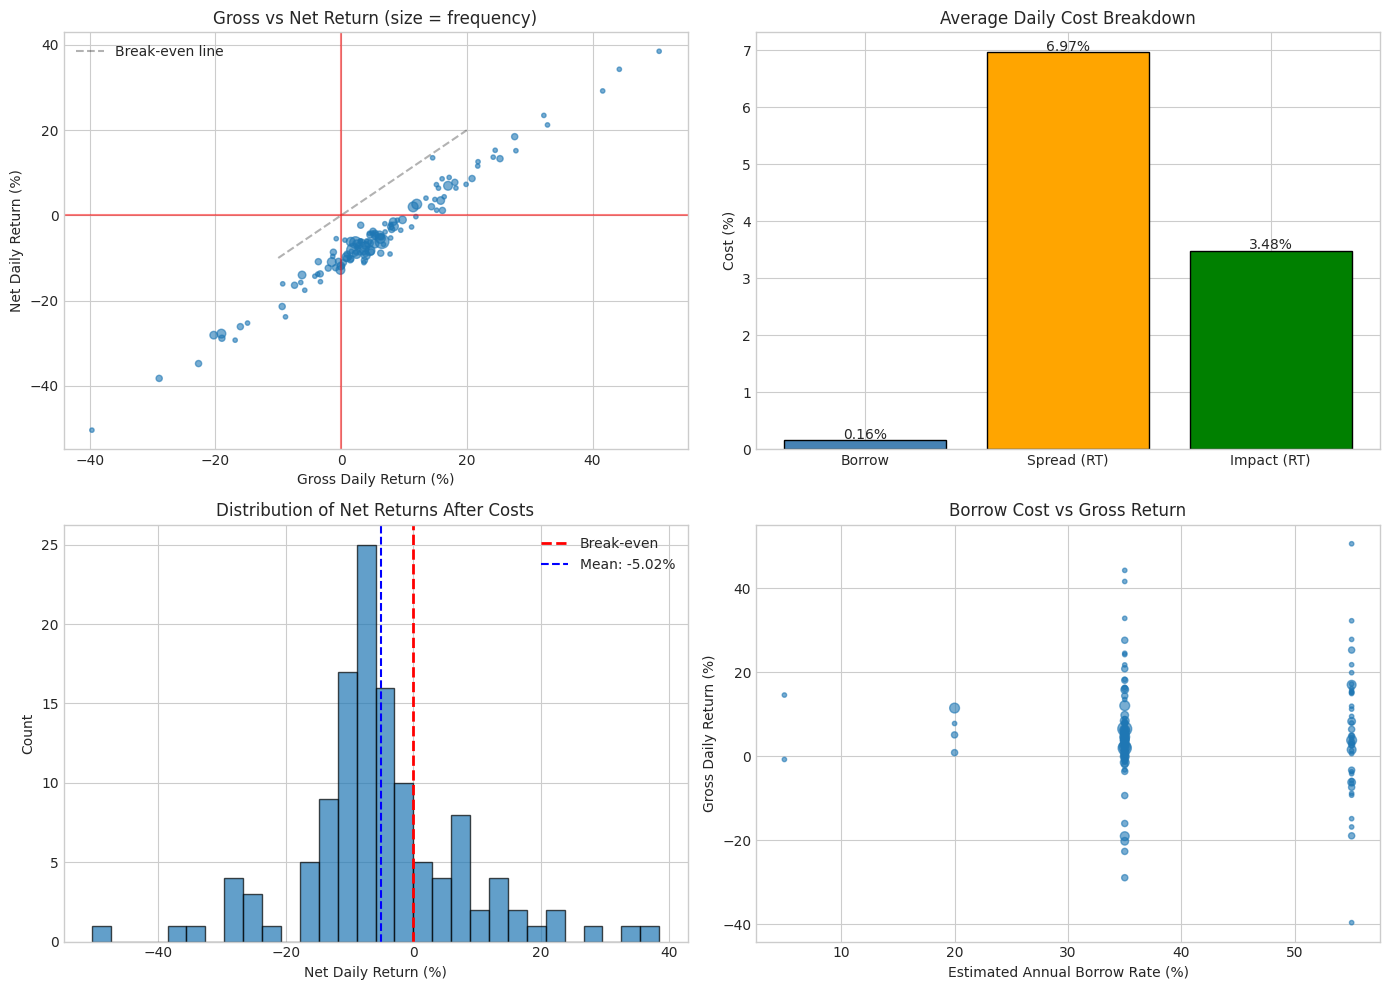

In [24]:
# Visualize
fig, axes = plt.subplots(2, 2, figsize=(14, 10))

# Gross vs Net return
ax = axes[0, 0]
ax.scatter(analysis['gross_daily_return'] * 100, analysis['net_daily_return'] * 100, 
           s=analysis['times_shorted'] * 10, alpha=0.6)
ax.plot([-10, 20], [-10, 20], 'k--', alpha=0.3, label='Break-even line')
ax.axhline(0, color='red', linestyle='-', alpha=0.5)
ax.axvline(0, color='red', linestyle='-', alpha=0.5)
ax.set_xlabel('Gross Daily Return (%)')
ax.set_ylabel('Net Daily Return (%)')
ax.set_title('Gross vs Net Return (size = frequency)')
ax.legend()

# Cost breakdown
ax = axes[0, 1]
costs = ['daily_borrow_cost', 'spread_cost_rt', 'market_impact_rt']
cost_labels = ['Borrow', 'Spread (RT)', 'Impact (RT)']
cost_means = [analysis[c].mean() * 100 for c in costs]
ax.bar(cost_labels, cost_means, color=['steelblue', 'orange', 'green'], edgecolor='black')
ax.set_ylabel('Cost (%)')
ax.set_title('Average Daily Cost Breakdown')
for i, v in enumerate(cost_means):
    ax.text(i, v + 0.02, f'{v:.2f}%', ha='center')

# Distribution of net returns
ax = axes[1, 0]
ax.hist(analysis['net_daily_return'] * 100, bins=30, edgecolor='black', alpha=0.7)
ax.axvline(0, color='red', linestyle='--', linewidth=2, label='Break-even')
ax.axvline(analysis['net_daily_return'].mean() * 100, color='blue', linestyle='--', 
           label=f'Mean: {analysis["net_daily_return"].mean()*100:.2f}%')
ax.set_xlabel('Net Daily Return (%)')
ax.set_ylabel('Count')
ax.set_title('Distribution of Net Returns After Costs')
ax.legend()

# Borrow rate vs return
ax = axes[1, 1]
ax.scatter(analysis['est_borrow_rate'], analysis['gross_daily_return'] * 100, 
           s=analysis['times_shorted'] * 10, alpha=0.6)
ax.set_xlabel('Estimated Annual Borrow Rate (%)')
ax.set_ylabel('Gross Daily Return (%)')
ax.set_title('Borrow Cost vs Gross Return')

plt.tight_layout()
plt.show()

## 5. Summary

In [25]:
print("=" * 70)
print("BORROW COST & TRADABILITY SUMMARY")
print("=" * 70)

print(f"""
SWEET SPOT ANALYSIS ($1M-$8M daily volume)
-------------------------------------------
Symbols analyzed: {len(analysis)}
Total positions: {analysis['times_shorted'].sum()}

BORROW COSTS (from IBorrowDesk + estimates):
  Median annual rate: {analysis['est_borrow_rate'].median():.1f}%
  Mean annual rate: {analysis['est_borrow_rate'].mean():.1f}%
  
ESTIMATED SPREADS:
  Median spread: {analysis['estimated_spread'].median()*100:.2f}%
  Mean spread: {analysis['estimated_spread'].mean()*100:.2f}%

TOTAL COSTS (daily):
  Borrow: {analysis['daily_borrow_cost'].mean()*100:.3f}%
  Spread (RT): {analysis['spread_cost_rt'].mean()*100:.3f}%
  Impact (RT): {analysis['market_impact_rt'].mean()*100:.3f}%
  TOTAL: {analysis['total_daily_cost'].mean()*100:.3f}%

RETURNS:
  Gross weighted daily: {weighted_gross*100:.3f}% ({weighted_gross*252*100:.1f}% ann)
  Net weighted daily: {weighted_net*100:.3f}% ({weighted_net*252*100:.1f}% ann)
  Cost eats: {weighted_cost/weighted_gross*100:.1f}% of gross

TRADABILITY:
  Symbols profitable after costs: {n_profitable}/{len(analysis)} ({n_profitable/len(analysis)*100:.1f}%)
  Positions in profitable symbols: {positions_profitable}/{total_positions} ({positions_profitable/total_positions*100:.1f}%)
""")

# Final verdict
if weighted_net > 0.01:  # > 1% daily
    verdict = "POTENTIALLY VIABLE - substantial alpha remains after estimated costs"
elif weighted_net > 0:
    verdict = "MARGINAL - small positive return, may not survive real-world friction"
else:
    verdict = "NOT VIABLE - costs exceed gross returns"

print(f"VERDICT: {verdict}")
print("\nNote: These are rough estimates. Paper trading will reveal true costs.")

BORROW COST & TRADABILITY SUMMARY

SWEET SPOT ANALYSIS ($1M-$8M daily volume)
-------------------------------------------
Symbols analyzed: 124
Total positions: 260

BORROW COSTS (from IBorrowDesk + estimates):
  Median annual rate: 35.0%
  Mean annual rate: 41.0%
  
ESTIMATED SPREADS:
  Median spread: 3.47%
  Mean spread: 3.48%

TOTAL COSTS (daily):
  Borrow: 0.163%
  Spread (RT): 6.966%
  Impact (RT): 3.483%
  TOTAL: 10.611%

RETURNS:
  Gross weighted daily: 4.418% (1113.4% ann)
  Net weighted daily: -6.241% (-1572.7% ann)
  Cost eats: 241.2% of gross

TRADABILITY:
  Symbols profitable after costs: 31/124 (25.0%)
  Positions in profitable symbols: 50/260 (19.2%)

VERDICT: NOT VIABLE - costs exceed gross returns

Note: These are rough estimates. Paper trading will reveal true costs.
